<a href="https://colab.research.google.com/github/johnnyd212/comp551-assignment-2/blob/main/analysis%201-2-3-early-stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
!pip install numpy pandas matplotlib sys pathlib itertools warnings imp

ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))



## Task 0: Pre-processing

### Loading the data

Our CSV file is unlabeled, so we create our column names following the description in spambase.DOCUMENTATION:

In [183]:
import numpy as np
import itertools

# let y^(i)_hat \in [0, 1] be our prediction (a probability)
# that x^{(i)} is a yes-instance of the class.

# For our logistic classifier, y^{(i)}_hat := \sigma(w^T x^{(i)})

# The likelihood of our model classifying x^(i) correctly is
# the Bernoulli(y^{(i)} ; y^(i)_hat)
# = (\hat{y}^{(i)})^{y^{(i)}} * (1 - \hat{y}^{(i)})^{1 - y^{(i)}}

# Thus the negative log likelihood is then
# - y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{y}^{(i)})

# This is the objective function of our logistic classifier.
def cross_entropy_loss(pred, y):
  eps = 1e-15
  pred = np.clip(pred, eps, 1 - eps)  # prevent log(0)
  return (-y * np.log(pred) - (1 - y) * np.log(1 - pred)).sum()


# A numerically stable implementation of the sigmoid function
# using the "logsumexp" trick
def sigmoid(z):
    # Set c to be the elementwise max of 0 and -z
    c = np.maximum(0, -z)

    try:
        return np.exp(-c - np.log(np.exp(-c) + np.exp(-z - c)))
    except RuntimeWarning:
            print('Exponential overflow in sigmoid')


class LogisticRegressor:
    def __init__(self,
                 batch_size=1,
                 learning_rate=0.0005,
                 num_epochs=100,
                 regularization_strength=0,
                 early_stopping = False
                 seed=None):

        self.batch_size = batch_size
        self.learning_rate=learning_rate
        self.num_epochs=num_epochs
        self.regularization_strength = regularization_strength
        self.early_stopping = early_stopping

        self.rng = np.random.default_rng(seed)

    # TODO: implement ADAM
    # TODO: Is it possible to get a fully vectorized implementation
    #       that eliminates the need for the outerloop?
    # TODO: clip predictions to prevent log(0), clip gradients for numerical stability
    def fit(self, X, y, learning_curve=False, add_bias=True):
        if add_bias:
            # Concatenate 1's for bias terms
            X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        self.weights = self.rng.random((X.shape[1], 1))

        #if(learning_curve): REMOVE, otherwise it doesn't work
        errors = []

        epochs_since_improvement = 0
        min_loss = float('inf')
        epoch_count = 0

        while(epoch_count < self.num_epochs and epochs_since_improvement < 10):
            # Permutation to apply to our rows for stochasticity
            indices = self.rng.permutation(X.shape[0])
            epoch_count = epoch_count + 1

            for batch in itertools.batched(indices, self.batch_size):
                # Convert to ndarray to trigger advanced indexing
                ndbatch = np.asarray(batch)
                # Weight update
                try:
                    self.weights -= self.learning_rate * self.loss_gradient(X[ndbatch], y[ndbatch])
                except TypeError:
                    print('Prediction error')
            if (self.early_stopping):
                loss = self.loss(X, y)
                if loss < min_loss:
                    min_loss = loss
                else:
                    epochs_since_improvement += 1


            if(learning_curve):
                try:
                    errors.append(self.loss(X, y))
                except RuntimeWarning:
                    print('Division by 0 in log')

        return errors



    # Our loss is the L2-regularized cross entropy loss
    def loss(self, X, y):
        ce_loss = cross_entropy_loss(self.predict(X), y)
        # Exclude bias term from regularization penalty
        reg_penalty = (self.regularization_strength / 2) * np.sum(self.weights[1:] ** 2)
        return ce_loss + reg_penalty


  #For data analysis, it is the sum of True Positives () and True Negatives () divided by the total sample size ().

    # The gradient of our loss function
    def loss_gradient(self, X, y):
        grad = X.T @ (self.predict(X) - y)
        # Add derivative term for regularization
        grad[1:] += self.regularization_strength * self.weights[1:]
        return grad

    # prediction of logistic classifer use the sigmoid function
    def predict(self, X, add_bias = False):
        # If X doesn't have the bias column (i.e., its number of columns is one less than the number of weights), add a column of ones.
        if X.shape[1] == self.weights.shape[0] - 1:
            X_with_bias = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
            return sigmoid(X_with_bias @ self.weights)
        elif X.shape[1] == self.weights.shape[0]:
            # X already has the bias column (or model was fitted without bias)
            return sigmoid(X @ self.weights)
        else:
            raise ValueError("Input X dimensions do not match model's weights.")

    #Score Accuracy
    def accuracy(self, X, y):
        good_predictions = ((self.predict(X) > 0.5) == y)
        return np.mean(good_predictions)

In [184]:
word_freq_names = [f'word_freq_{i}' for i in range(1, 49)]
char_freq_names = [f'char_freq_{i}' for i in range(1, 7)]
cap_run_features = ['capital_run_length_' + s for s in ['average', 'longest', 'total']]

col_names = (
    word_freq_names +
    char_freq_names +
    cap_run_features +
    ['spam']
)

In [185]:
df = pd.read_csv('spambase.data', header=None, names=col_names)
df.head()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Feature normalization

We can see that the ranges of the values for our integral features are quite large relative to our word and char frequencies:

In [186]:
df[cap_run_features].describe()

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000
mean,5.191515,52.172789,283.289285
std,31.729449,194.891310,606.347851
min,1.000000,1.000000,1.000000
25%,1.588000,6.000000,35.000000
50%,2.276000,15.000000,95.000000
75%,3.706000,43.000000,266.000000
max,1102.500000,9989.000000,15841.000000


I tried to train the regressor without normalizing at first, but the sigmoid function saturated, and we were getting numerical issues of taking logs of 0 in our cross entropy loss as a consequence. To address this, we use min-max normalization to make our integral count features in line with our 0-1 word and char frequency features.

In [187]:
cap_minima = df[cap_run_features].min()
cap_maxima = df[cap_run_features].max()

df[cap_run_features] =  ( (df[cap_run_features] - cap_minima) /
                         (cap_maxima - cap_minima) )

In [188]:
df[cap_run_features].describe()

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000
mean,0.003805,0.005123,0.017821
std,0.028806,0.019513,0.038280
min,0.000000,0.000000,0.000000
25%,0.000534,0.000501,0.002146
50%,0.001158,0.001402,0.005934
75%,0.002457,0.004205,0.016730
max,1.000000,1.000000,1.000000


### Random Seed

For reproducibility, we'll set the seed for the random generators we use (e.g. for train-test spliiting, stochastic gradient descent, etc...).

In [189]:
rng_seed = 551
rng = np.random.default_rng(seed=rng_seed)

### Train-test split

We'll implement a train-test split of 5-95, that is, we use 5% of the data for training, and hold out the remaining 95% for testing. (In the interest of implementing our classifier from 'scratch', we don't use train_test_split from scikit-learn.)

In [190]:
train_ratio = 0.05
N = len(df)

# Train-test split
df_perm = df.iloc[rng.permutation(N)]
split_index = int(N * train_ratio)
df_train = df_perm.iloc[:split_index]
df_test = df_perm.iloc[split_index:]

X_train = df_train.drop(columns=['spam'])
y_train = df_train['spam']
X_test = df_test.drop(columns=['spam'])
y_test = df_test['spam']

## Task 1: Logistic Regression with SGD

We'll initialize two logistic regressors, one with no regularization and the other with regularization strength 0.001, to compare their loss curves. We'll initialize the remaining hyperparameters to the following values:
- batch_size = 1
- learning_rate = 0.01
- num_epochs = 100

In [191]:
reg_str = 0.001

In [192]:
model_no_reg = LogisticRegressor(seed=551)
model_reg = LogisticRegressor(regularization_strength=reg_str, seed=551)

learning_curve_no_reg = model_no_reg.fit(X_train.to_numpy(), y_train.to_numpy(),
                                         learning_curve=True)
learning_curve_reg = model_reg.fit(X_train.to_numpy(), y_train.to_numpy(),
                                   learning_curve=True)

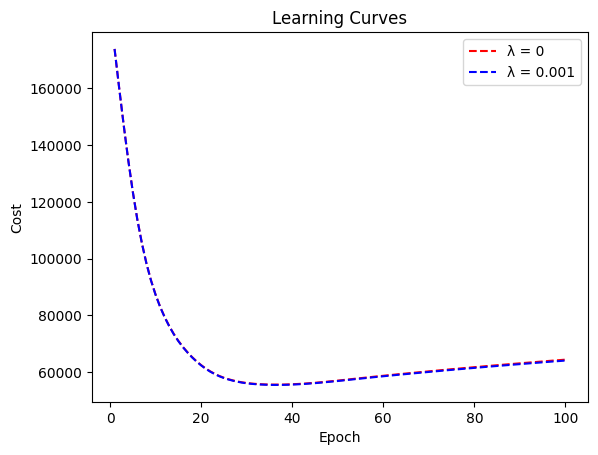

In [193]:
plt.plot(np.arange(1, model_no_reg.num_epochs + 1),
            learning_curve_no_reg,
            'r--', label='\u03BB = 0')
plt.plot(np.arange(1, model_reg.num_epochs + 1),
            learning_curve_reg,
            'b--', label=f'\u03BB = {reg_str}')

plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()

# **Part 2: Hyperparameter Tuning with K-Fold Cross Validation**

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange
from sklearn.model_selection import ParameterGrid
import itertools # Added for completeness as it's used in LogisticRegressor

def knuth_shuffle(x):
    for i in range(len(x)-1, 0, -1):
        j = randrange(i + 1)
        x[i], x[j] = x[j], x[i]
    return x

def k_fold_validation(train_x, train_y, model_class, params, n_folds=5):
  '''
  This function performs k-fold validation and returns the average validation loss
  '''

  if n_folds is None:
    n_folds = train_x.shape[0]
  # Ensure n_folds is not greater than the number of samples in X_data
  if n_folds > train_x.shape[0]:
      print(f"Warning: n_folds ({n_folds}) is greater than number of samples ({train_x.shape[0]}). Setting n_folds to number of samples.")
      n_folds = train_x.shape[0]

  # K-fold Validation
  # Convert to numpy arrays before splitting to avoid iloc/index issues with potentially modified index after splitting
  X_data_np = train_x.to_numpy()
  y_data_np = train_y.to_numpy().reshape(-1, 1) # Reshape y to (N, 1) right away for consistency

  indices = list(range(X_data_np.shape[0]))
  knuth_shuffle(indices)
  folds = np.array_split(indices, n_folds)

  d_features = X_data_np.shape[1]
  validation_loss_array = np.zeros(n_folds)
  validation_accuracy_array = np.zeros(n_folds)
  train_loss_array = np.zeros(n_folds)
  train_accuracy_array = np.zeros(n_folds)

  for i in range(n_folds):
    # Identify validation set indices and training set indices for the current fold
    validation_index = folds[i]
    training_index = np.concatenate([f for j, f in enumerate(folds) if j != i])

    # Split data using the numpy arrays
    validation_x_fold = X_data_np[validation_index]
    train_x_fold = X_data_np[training_index]

    validation_y_fold = y_data_np[validation_index]
    train_y_fold = y_data_np[training_index]

    model = model_class(**params)

    # This portion might be worth modifying if we use a model that uses gradient instead
    model.fit(train_x_fold, train_y_fold) # train_y_fold is already (N_fold, 1)

    # Calculate loss and accuracy - pass features (X) and true labels (y)
    # The model's loss and accuracy methods will call model.predict(X) internally
    validation_loss_array[i] = model.loss(validation_x_fold, validation_y_fold)
    train_loss_array[i] = model.loss(train_x_fold, train_y_fold)

    validation_accuracy_array[i] = model.accuracy(validation_x_fold, validation_y_fold)
    train_accuracy_array[i] = model.accuracy(train_x_fold, train_y_fold)

  avg_val_loss = np.mean(validation_loss_array)
  std_val_loss = np.std(validation_loss_array)
  avg_val_accuracy = np.mean(validation_accuracy_array)

  avg_train_loss = np.mean(train_loss_array)
  std_train_loss = np.std(train_loss_array)
  avg_train_accuracy = np.mean(train_accuracy_array)

  return d_features, avg_val_loss, std_val_loss, avg_val_accuracy, avg_train_loss, std_train_loss, avg_train_accuracy


def model_selection (model_classes, param_grid, train_x, train_y, n_folds = None):
  '''
  iterates through each combination of hyperparameter
  '''
  if n_folds is None:
    n_folds = train_x.shape[0]

  fold_losses = []
  fold_params = []
  all_d_features = []
  std_vals = []

  for model_class in model_classes:
    print("Model_Class: " + str(model_class))

    for params in ParameterGrid(param_grid):
      d_features, avg_val_loss, std_val_loss, avg_val_accuracy, _ , _, _ = k_fold_validation(train_x, train_y, model_class, params, n_folds = n_folds)
      fold_losses.append(avg_val_loss)
      fold_params.append(params)
      all_d_features.append(d_features)
      std_vals.append(std_val_loss)

  # Convert to numpy arrays for easier indexing and calculations
  fold_losses = np.array(fold_losses)
  all_d_features = np.array(all_d_features)

  std_val_loss = np.std(fold_losses)
  min_val_loss = np.min(fold_losses)


  all_candidates = zip(all_d_features, fold_losses, std_vals, fold_params)

  loss_candidates = np.where(fold_losses <= (min_val_loss+std_val_loss))[0]

  fold_losses = np.array(fold_losses)
  fold_params = np.array(fold_params)
  all_d_features = np.array(all_d_features)

  cand_features = all_d_features[loss_candidates]
  cand_losses = fold_losses[loss_candidates]
  cand_params = [fold_params[i] for i in loss_candidates]

  cands = zip(cand_features, cand_losses, cand_params)
  sorted_cands = sorted(cands, key=lambda x:(x[0], x[1]))

  best_model = sorted_cands[0]
  print ("The best model is "+ str(best_model[2]) + ". It has " + (str(best_model[0]) + " features, and produces a loss of " + str(best_model[1])))

  return best_model, all_candidates


param_grid = {
  "batch_size": [1, 16, 64],
  "learning_rate": [1, 0.1, 0.01, 0.001, 0.0001],
  "num_epochs": [50, 100, 200],
  "regularization_strength": [0.001]
}


model_classes = [LogisticRegressor]
best_model, _ = model_selection(model_classes, param_grid, X_train, y_train, n_folds = 100)


Model_Class: <class '__main__.LogisticRegressor'>
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49
Fold: 50
Fold: 51
Fold: 52
Fold: 53
Fold: 54
Fold: 55
Fold: 56
Fold: 57
Fold: 58
Fold: 59
Fold: 60
Fold: 61
Fold: 62
Fold: 63
Fold: 64
Fold: 65
Fold: 66
Fold: 67
Fold: 68
Fold: 69
Fold: 70
Fold: 71
Fold: 72
Fold: 73
Fold: 74
Fold: 75
Fold: 76
Fold: 77
Fold: 78
Fold: 79
Fold: 80
Fold: 81
Fold: 82
Fold: 83
Fold: 84
Fold: 85
Fold: 86
Fold: 87
Fold: 88
Fold: 89
Fold: 90
Fold: 91
Fold: 92
Fold: 93
Fold: 94
Fold: 95
Fold: 96
Fold: 97
Fold: 98
Fold: 99
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold

# **Part 3: Bias-Variance Trade-Off via λ Sweep**

In [ ]:
import numpy as np

# Generate values from 1e-6 to 1 on a log scale
regularization_strength = np.logspace(-6, 0, num=25)  # 25 values from 1e-6 to 1

# Optionally, include 0 explicitly if your model supports it
regularization_strength = np.insert(regularization_strength, 0, 0)



param_grid = {
    "batch_size": [16],
    "learning_rate": [0.1],
    "num_epochs": [200],
    "regularization_strength": regularization_strength
}


def lambda_sweep (model_classes, param_grid, train_x, train_y, n_folds = 100):
  '''
  iterates through each combination of hyperparameter
  '''
  shape = [len(v) for v in list(param_grid.values())]
  d_features_grid = np.zeros(shape)
  val_loss_grid = np.zeros(shape)

  lambda_array = []

  train_fold_losses = []
  train_fold_accuracy = []
  train_fold_params = []

  val_fold_losses = []
  val_fold_accuracy = []
  val_fold_params = []
  all_d_features = []
  std_vals = []




  for model_class in model_classes:

    for params in ParameterGrid(param_grid):
      model = model_class(**params)
      d_features, avg_val_loss, std_val_loss, avg_val_accuracy, avg_train_loss, std_train_loss, avg_train_accuracy = k_fold_validation(train_x, train_y, model_class, params, n_folds)

      #Append Losses, Parameters, and Accuracy for validation set
      val_fold_losses.append(avg_val_loss)
      val_fold_accuracy.append(avg_val_accuracy)
      val_fold_params.append(params)

      #Append Losses, Parameters, and Accuracy for test set
      train_fold_losses.append(avg_train_loss)
      train_fold_accuracy.append(avg_train_accuracy)
      train_fold_params.append(params)
      std_vals.append(std_val_loss)


      lambda_array.append(params["regularization_strength"])

      all_d_features.append(d_features)

      #d_features_grid.append(d_features)


  #Graph relationship between log lambda and training/validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(lambda_array, val_fold_losses, marker = 'o')
  plt.plot(lambda_array, train_fold_losses, marker = 'o')
  plt.xscale('log')
  plt.legend(["Validation Loss", "Training Loss"])
  plt.xlabel("Log Lambda")
  plt.ylabel("Loss")
  plt.title("Loss vs Lambda")
  plt.show()


  #Graph relationship between log lambda and training/validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(lambda_array, val_fold_accuracy, marker = 'o')
  plt.plot(lambda_array, train_fold_accuracy, marker = 'o')
  plt.xscale('log')
  plt.legend(["Validation Accuracy", "Training Accuracy"])
  plt.xlabel("Log Lambda")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Lambda")
  plt.show()


  #Model Selection based on standard deviation + model complexity
  std_val_loss = np.std(val_fold_losses)
  min_val_loss = np.min(val_fold_losses)

  all_candidates = zip(all_d_features, fold_losses, std_val_loss, fold_params)


  loss_candidates = np.where(val_fold_losses <= (min_val_loss+std_val_loss))[0]


  fold_losses = np.array(val_fold_losses)
  fold_params = np.array(val_fold_params)
  all_d_features = np.array(all_d_features)


  cand_features = all_d_features[loss_candidates]
  cand_losses = fold_losses[loss_candidates]
  cand_params = fold_params[loss_candidates]


  cands = zip(cand_features, cand_losses, cand_params)
  sorted_cands = sorted(cands, key=lambda x:(x[0], x[1]))

  best_model = sorted_cands[0]
  print ("The best model is "+ str(best_model[2]) + ". It has " + (str(best_model[0])) + "features, and produces a loss of " + (str(best_model[1])))

  return best_model, all_candidates


best_model = lambda_sweep(model_classes, param_grid, X_train, y_train)







Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49
Fold: 50
Fold: 51
Fold: 52
Fold: 53
Fold: 54
Fold: 55
Fold: 56
Fold: 57
Fold: 58
Fold: 59
Fold: 60
Fold: 61
Fold: 62
Fold: 63
Fold: 64
Fold: 65
Fold: 66
Fold: 67
Fold: 68
Fold: 69
Fold: 70
Fold: 71
Fold: 72
Fold: 73
Fold: 74
Fold: 75
Fold: 76
Fold: 77
Fold: 78
Fold: 79
Fold: 80
Fold: 81
Fold: 82
Fold: 83
Fold: 84
Fold: 85
Fold: 86
Fold: 87
Fold: 88
Fold: 89
Fold: 90
Fold: 91
Fold: 92
Fold: 93
Fold: 94
Fold: 95
Fold: 96
Fold: 97
Fold: 98
Fold: 99
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fol